<h1>Sequence analysis</h1>

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import hdbscan
from spot import spot, tools
from scipy.io import loadmat
from scipy import ndimage

In [2]:
root = '/home/vladimir/Sequences/'

In [3]:
root = 'D:\\Work\\Sequence analysis\\'

In [21]:
#Load matlab workspaces with full-featured analysis (including ripples and SCEs) of sleep session alone 
#and with place fields of that neurons in awake session
sleep_mat = loadmat(root + 'SleepPOST_all_data_new_CNMF.mat')
pf_mat = loadmat(root + 'Neurons_PFs_new_CNMF.mat')

In [18]:
pf_mat['Neurons']['NormedSummedPlaceActivity'][0,0][0,:][1][0]

array([[0.00000000e+00, 0.00000000e+00, 9.41067391e-03, 8.23433967e-03,
        7.31941304e-03, 7.31941304e-03, 7.31941304e-03, 7.31941304e-03,
        7.31941304e-03, 7.31941304e-03, 7.31941304e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.92776522e-02, 4.87960870e-02, 4.87960870e-02, 4.87960870e-02,
        4.87960870e-02, 4.87960870e-02, 4.87960870e-02, 4.87960870e-02,
        4.87960870e-02, 1.95184348e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [35]:
#pf_mat['Neurons']['PFs'][0,0][i_neur, 0][i_dir][i_pf][0][0], all zeros are obligatory
#pf_mat['Neurons']['isPC'][0, 0][120, 0][1][0][0][0][0], all zeros are obligatory

array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96],
      dtype=uint8)

In [27]:
#calculate c.o.m. of all valid place fields for each neuron in each direction
nNeurons = pf_mat['Neurons']['PFs'][0, 0].shape[0]
pfcm = []
pfdistrib = []
for i_dir in range(2):
    pfcm_dir = []
    pfdistrib_dir = []
    for i_neur in range(nNeurons):
        pfs = pf_mat['Neurons']['PFs'][0, 0][i_neur, 0][i_dir]
        ispcs = pf_mat['Neurons']['isPC'][0, 0][i_neur, 0][i_dir]
        distr = pf_mat['Neurons']['NormedSummedPlaceActivity'][0,0][0,i_neur][i_dir][0]
        neur = []
        for pf, ispc in zip(pfs, ispcs):
            if ispc[0][0][0]:
                neur += pf[0][0].tolist()
        pfcm_dir.append(np.mean(neur))
        pfdistrib_dir.append(distr)
    pfcm.append(pfcm_dir)
    pfdistrib.append(pfdistrib_dir)

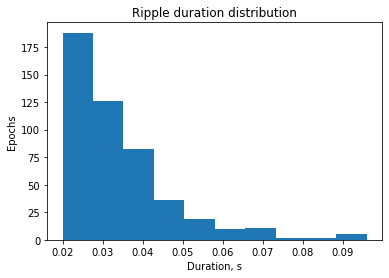

In [3]:
durs = [rip[2] - rip[0] for rip in mat['ripples']]
ax = plt.subplot()
ax.hist(durs)
ax.set_title('Ripple duration distribution')
ax.set_ylabel('Epochs')
ax.set_xlabel('Duration, s');

In [33]:
#Construct data structure of spike times as describen in SPOTDisClust for further analysis
spike_times = [] #solid massive for all spike times (relative to the epoch start) of all neurons in all epochs
ii_spike_times = [] #indices in spike_times for each neuron in each epoch, like [[[i_start, i_end], [same for the next neuron],..], [same for the next epoch],...]
duration = 0.2 #around-ripple epoch duration in seconds
fps = 100
duration_frames = int(duration*fps)
n_neurons = len(sleep_mat['EvtStarts'])
nbEvents = [] #number of events per epoch
minev = 10 #minimum number of events per epoch
nbEvents_valid =[] #number of events per valid epoch (i.e., passed by minev criterium)
cnt = 0 #counter of spikes

neurotime = sleep_mat['TTLstartsTimes']
#neurotime -= neurotime[0]

def time2ind(t):
    return np.where(neurotime >= t)[0][0]

for ripple in sleep_mat['ripples']:
    epoch = []
    ep_spike_times = []
    ep_start = time2ind(ripple[1]-duration/2)  #epoch start time in indices 
    rip_start = time2ind(ripple[0]) - ep_start #ripple start time in indicices (relative to the epoch start)
    rip_end = time2ind(ripple[2]) - ep_start   #ripple end time in indicices (relative to the epoch start)
    
    for neuron in sleep_mat['EvtStarts']:
        events = np.array(neuron[ep_start:ep_start + duration_frames])
        
        events[:rip_start] = 0 #drop all the events in the current epoch outside the current ripple
        events[rip_end:] = 0
        
        inds = np.nonzero(events)[0]/fps                #spike times and indices,
        ep_spike_times += inds.tolist()                 #realtive to the epoch start
        epoch.append([cnt, cnt+len(inds)])
        cnt += len(inds)
        
    if len(ep_spike_times) >= minev:
        spike_times += ep_spike_times
        ii_spike_times.append(epoch)
        nbEvents_valid.append(len(ep_spike_times))
    else:
        cnt -= len(ep_spike_times)
        
    nbEvents.append(len(ep_spike_times))
        
ii_spike_times = np.array(ii_spike_times)
nbEpochs = len(nbEvents_valid)
print(f'Constructed {nbEpochs} epochs from {len(nbEvents)} ripples\nFound {sum(nbEvents_valid)} events, av. {sum(nbEvents_valid)/nbEpochs:.1f} per epoch')

Constructed 310 epochs from 481 ripples
Found 7566 events, av. 24.4 per epoch


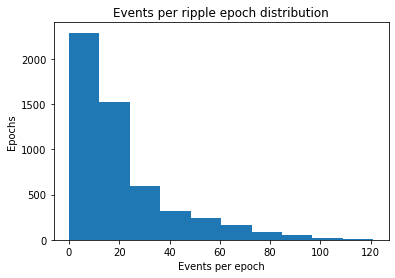

In [16]:
ax = plt.subplot()
ax.hist(nbEvents)
ax.set_title('Events per ripple epoch distribution')
ax.set_ylabel('Epochs')
ax.set_xlabel('Events per epoch');

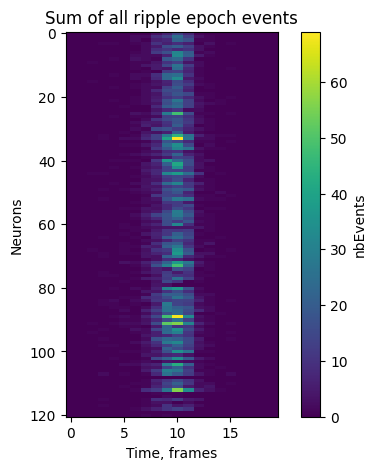

In [25]:
plt.figure(figsize = (6,5), dpi = 100)
ax = plt.subplot()
ax.set_title('Sum of all ripple epoch events')

sum_events = np.zeros((n_neurons, duration_frames)) 
for epoch in ii_spike_times:
    for i_neuron, neuron in enumerate(epoch):
        sp_indices = spike_times[neuron[0]:neuron[1]]
        for ind in sp_indices:
            sum_events[i_neuron, int(ind*fps)] += 1

plt.imshow(sum_events, aspect = 0.3) 
plt.colorbar().set_label('nbEvents')
plt.xlabel('Time, frames')
plt.ylabel('Neurons');

In [100]:
#deduct the order from the neuron-wise center of mass of summary events image
sum_cim = [ndimage.center_of_mass(row)[0] for row in sum_events]
order = np.argsort(sum_cim)

/home/vladimir/anaconda3/envs/spot/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


In [98]:
#center of mass of the first epoch
first_cim = [np.mean(spike_times[row[0]:row[1]]) for row in ii_spike_times[0]] 
order = np.argsort(first_cim)

/home/vladimir/anaconda3/envs/spot/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vladimir/anaconda3/envs/spot/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [36]:
#order of centers of mass of PFs in direction 1
order = np.argsort(pfcm[0])

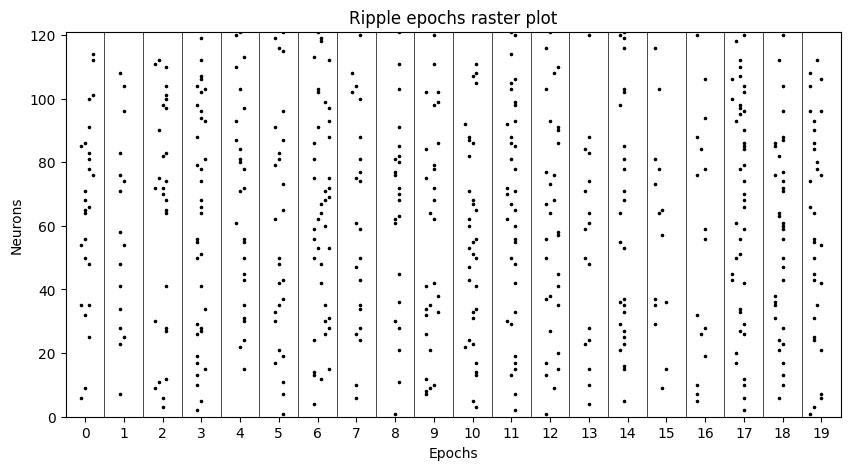

In [37]:
#Plot raster map of epochs in a row
interval = 0.1 #length between epoch centers on the plot
epochs_per_raw = 20 #number of epochs per raw

plt.figure(figsize = (10,5), dpi = 100)
ax = plt.subplot()
ax.set_title('Ripple epochs raster plot')
ax.set_xticks(np.linspace(interval, epochs_per_raw*interval, epochs_per_raw), labels = [str(i) for i in range(epochs_per_raw)])
ax.set_xlim(interval*0.5, interval*(epochs_per_raw + 0.5))
ax.set_ylim(0, n_neurons)
ax.set_xlabel('Epochs')
ax.set_ylabel('Neurons')

for i_epoch, epoch in enumerate(ii_spike_times[:epochs_per_raw]):
    ax.axvline(interval*(i_epoch + 0.5), c = 'black', linewidth=0.5)
    for i_neuron, neuron in enumerate(epoch[order]):
        spikes = np.array(spike_times[neuron[0]:neuron[1]])
        ax.scatter(spikes + interval*i_epoch, np.ones(len(spikes))+i_neuron, c='black', marker='.', s=10)
        

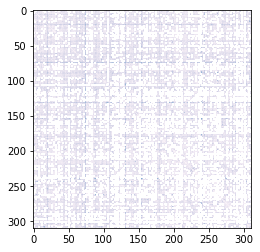

In [95]:
dissimilarities = spot.distances(spike_times, ii_spike_times, metric='SPOTD_xcorr')
plt.imshow(dissimilarities, cmap='PuBu')

In [102]:
clusterer = hdbscan.HDBSCAN(metric='precomputed')
cluster_labels = clusterer.fit_predict(np.nan_to_num(dissimilarities))
clusters = np.unique(cluster_labels)

print(len(clusters), 'clusters found')
for cl in clusters:
    print(f'Cluster # {cl} :{len(np.where(cluster_labels==cl)[0])} epochs') 
    

3 clusters found
Cluster # -1 :42 epochs
Cluster # 0 :101 epochs
Cluster # 1 :167 epochs


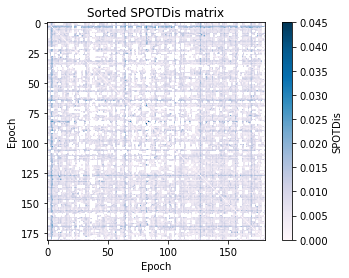

In [96]:
si = np.argsort(cluster_labels)
plt.title('Sorted SPOTDis matrix')
plt.imshow(dissimilarities[:, si][si], cmap='PuBu')
plt.colorbar().set_label('SPOTDis')
plt.xlabel('Epoch')
plt.ylabel('Epoch');

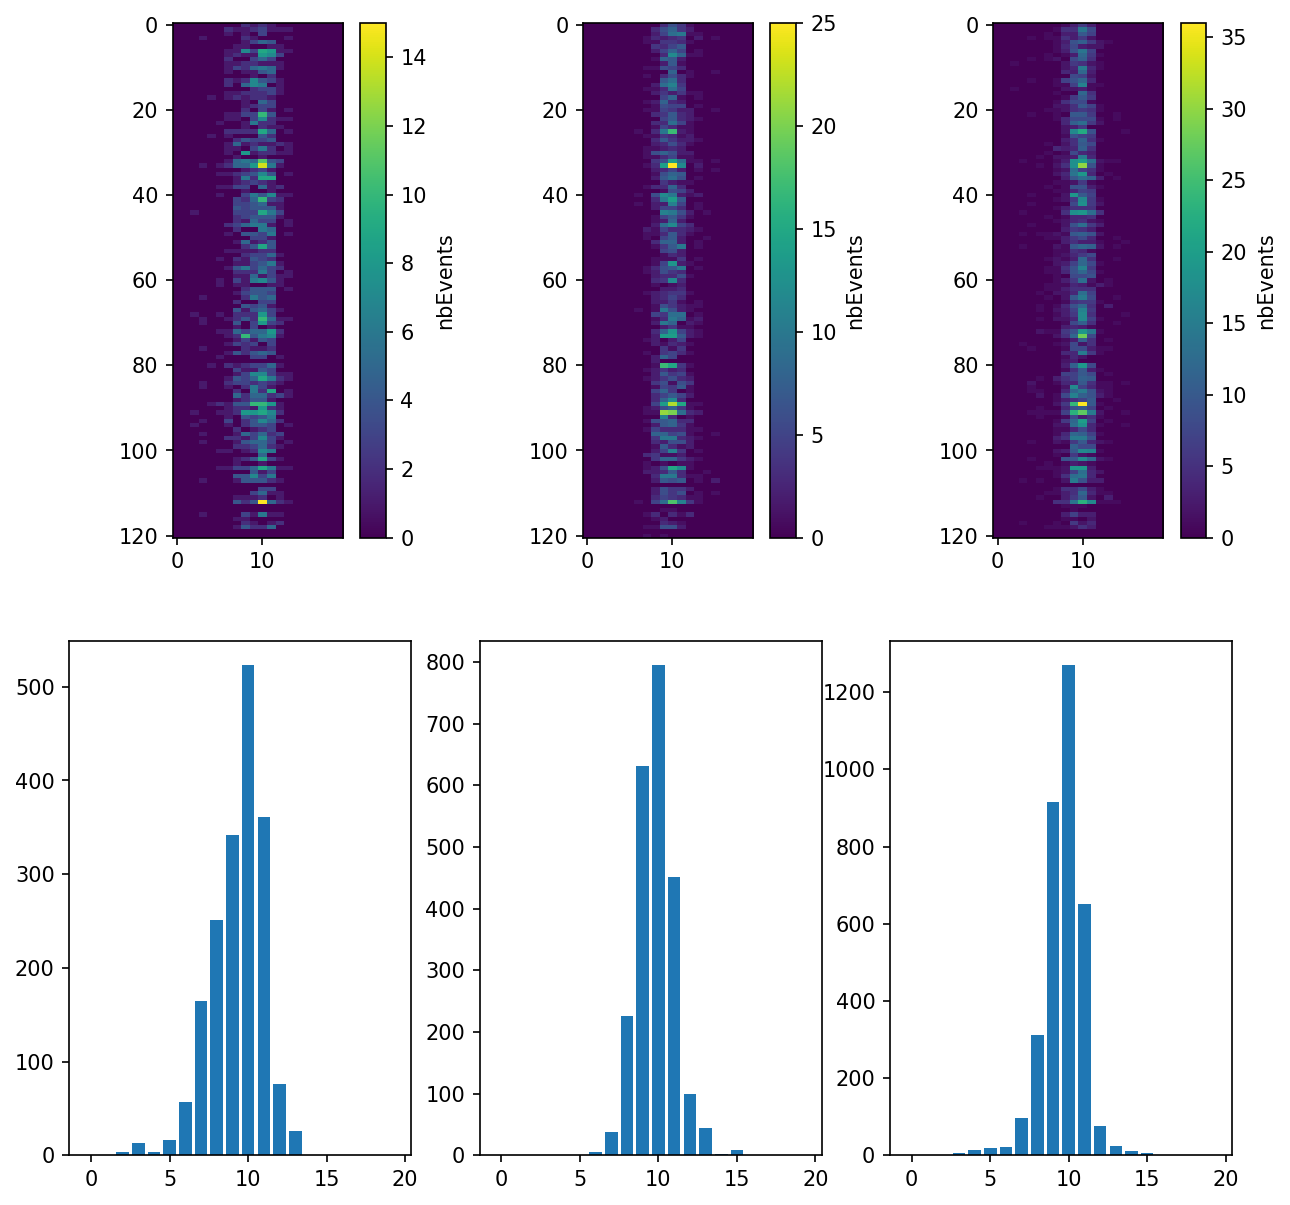

In [104]:
#show events distribution in clusters made of ripple and random epochs
cluster_event_sums = []    
n_clust = len(clusters)
figure, axes = plt.subplots(2,n_clust, figsize=(10, 10), dpi=150)
for icl, clust in enumerate(clusters):
    events2d = np.zeros((n_neurons, duration_frames))
    for nb_epoch in np.where(cluster_labels==clust)[0]:
        for i_neuron, neuron in enumerate(ii_spike_times[nb_epoch]):
            sp_indices = spike_times[neuron[0]:neuron[1]]
            for ind in sp_indices:
                events2d[i_neuron, int(ind*fps)] += 1
    plot = axes[0, icl].imshow(events2d, aspect = 0.5) 
    plt.colorbar(plot, ax=axes[0, icl]).set_label('nbEvents')
    axes[1, icl].bar(np.linspace(0,19,20), np.sum(events2d, axis = 0))
    cluster_event_sums.append(events2d)
    

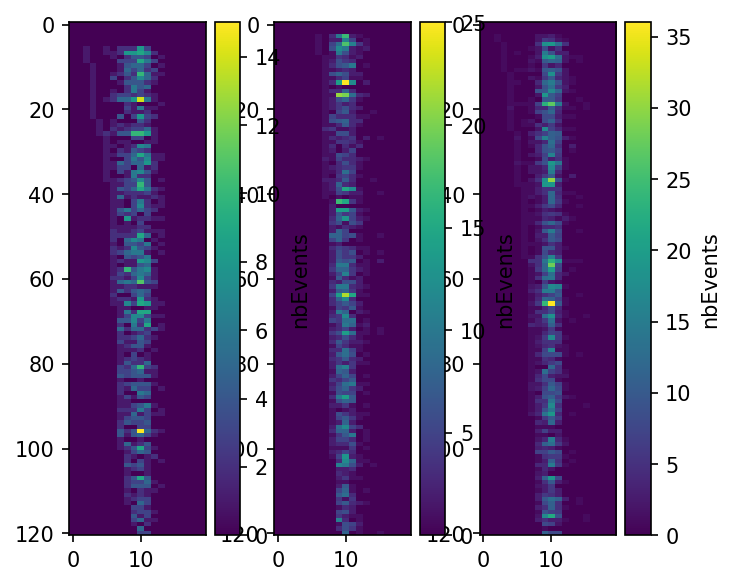

In [118]:
#show events distribution in clusters made of ripple and random epochs
figure, axes = plt.subplots(1,n_clust, figsize=(5, 10), dpi=150)
for icl, clust_sum in enumerate(cluster_event_sums):
    order = np.argsort(first_times)
    first_times = [0 if not np.count_nonzero(row) else np.nonzero(row)[0][0] for row in clust_sum]
    order = np.argsort(first_times)
    plot = axes[icl].imshow(clust_sum[order, :], aspect = 0.62) 
    plt.colorbar(plot, ax=axes[icl]).set_label('nbEvents')


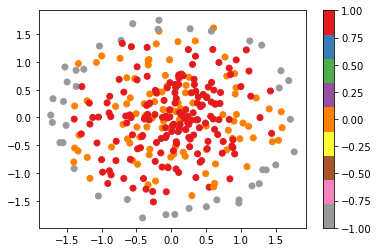

In [103]:
embedding = TSNE(metric='precomputed', n_components=2).fit_transform(np.nan_to_num(dissimilarities))
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Set1_r', c=cluster_labels)
plt.colorbar()

<h1>Sandbox</h1>

In [237]:
A = mat['ExtractedResults']['A'][0][0][:,5].todense()

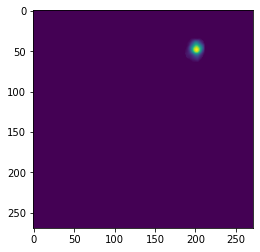

In [244]:
plt.imshow(A.reshape((269,272)))

<h1>Legacy</h1>

In [15]:
#append another batch of randomized non-ripple epochs (OPTIONAL!!!)
ii_spike_times = ii_spike_times.tolist()       #conversion for proper addition
rand_inds = np.random.randint(low = 0, high = mat['EvtStarts'].shape[1] - duration_frames, size = 10*len(mat['ripples'])) #rnadom indices sequence

for rnd in rand_inds:
    epoch = []
    ep_spike_times = []
    for neuron in mat['EvtStarts']:
        events = np.array(neuron[rnd:rnd + duration_frames])
        inds = np.nonzero(events)[0]/fps                #spike times and indices,
        ep_spike_times += inds.tolist()                 #realtive to the epoch start
        epoch.append([cnt, cnt+len(inds)])
        cnt += len(inds)
    if len(ep_spike_times) >= minev:
        spike_times += ep_spike_times
        ii_spike_times.append(epoch)
        nbEvents_valid.append(len(ep_spike_times))
    else:
        cnt -= len(ep_spike_times)
        
    nbEvents.append(len(ep_spike_times))
ii_spike_times = np.array(ii_spike_times)
print(f'Constructed {len(nbEvents_valid)} epochs from {len(nbEvents)} ripples and random points\nFound {sum(nbEvents_valid)} events, av. {sum(nbEvents_valid)/len(nbEvents_valid):.1f} per epoch')

Constructed 1962 epochs from 5291 ripples and random points
Found 80314 events, av. 40.9 per epoch


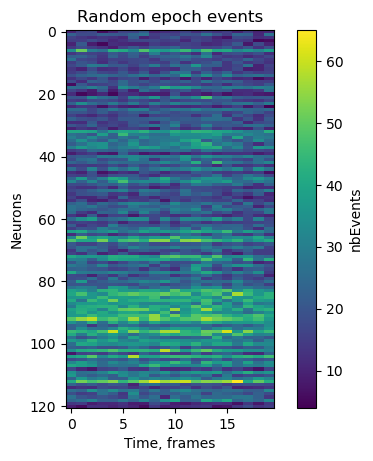

In [27]:
plt.figure(figsize = (6,5), dpi = 100)
ax = plt.subplot()
ax.set_title('Random epoch events')

events2d = np.zeros((n_neurons, duration_frames)) 
for rnd in rand_inds:
    pts = mat['EvtStarts'][:,rnd:rnd + duration_frames]
    if np.sum(pts) >= minev:
        events2d +=  pts
plt.imshow(events2d, aspect = 0.3) 
plt.colorbar().set_label('nbEvents')
plt.xlabel('Time, frames')
plt.ylabel('Neurons');

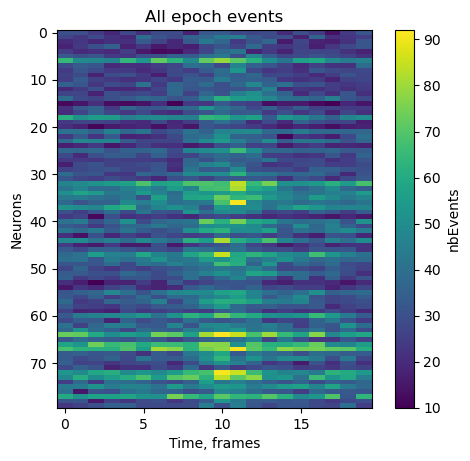

In [126]:
plt.figure(figsize = (6,5), dpi = 100)
ax = plt.subplot()

ax.set_title('All epoch events')
events2d = np.zeros((n_neurons, duration_frames))

for epoch in ii_spike_times:
    for i_neuron, neuron in enumerate(epoch):
        sp_indices = spike_times[neuron[0]:neuron[1]]
        for ind in sp_indices:
            events2d[i_neuron, int(ind*fps)] += 1

plt.imshow(events2d, aspect = 0.3) 
plt.colorbar().set_label('nbEvents')
plt.xlabel('Time, frames')
plt.ylabel('Neurons');